In [3]:
# 导入所需库
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image



In [4]:
# 定义图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize为224x224
    transforms.ToTensor(),          # 转为Tensor
])

# 数据根目录
data_dir = '../../Data/food-11'

# 训练集：只用有标签
train_dataset = datasets.ImageFolder(
    os.path.join(data_dir, 'training', 'labeled'),
    transform=transform
)

# 验证集
val_dataset = datasets.ImageFolder(
    os.path.join(data_dir, 'validation'),
    transform=transform
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 类别名
class_names = train_dataset.classes

# GPU/CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("使用设备：", device)


使用设备： cuda


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classed=11):
        super(SimpleCNN, self).__init__()

        # 卷积部分
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), # 输出16x224x224
            nn.ReLU(),
            nn.MaxPool2d(2), # 输出16x112x112
            nn.Conv2d(16, 32, 3, padding=1), # 输出32x112x112
            nn.ReLU(),
            nn.MaxPool2d(2), # 输出32x56x56
        )

        # 全连接部分
        # 先降维+非线性增强；再映射到分类空间
        self.fc = nn.Sequential(
            nn.Flatten(), # 输出100352
            nn.Linear(32 * 56 * 56, 256), # 输出256
            nn.ReLU(),
            nn.Linear(256, num_classed) # 输出11
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [6]:
# 模型训练
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, model_name='Model'):
    # TensorBoard日志
    writer = SummaryWriter(log_dir=f'runs/{model_name}')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # tqdm进度条
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            # 前向
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 反向
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 统计
            running_loss += loss.item() * inputs.size(0) # 累计损失：平均损失量x当前批次样本数量
            _, preds = torch.max(outputs, 1) # 获取模型预测的类别类型
            correct += (preds == labels).sum().item() # 正确预测数累计： .item()将结果转换为python标量
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100.*correct/total)

        # 平均指标
        epoch_loss = running_loss / total
        epoch_acc = correct / total

        # TensorBoard
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Accuracy/train', epoch_acc, epoch)

        # 验证
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels) # 
                val_loss += loss.item() * inputs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc  = val_correct / len(val_loader.dataset)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)

        print(f'Epoch {epoch+1}: Train Acc={epoch_acc:.4f}, Val Acc = {val_acc:.4f}')

    writer.close()

In [7]:
# 错误预测可视化
def show_misclassified(model, dataloader, num_images=5):
    model.eval()
    misclassifed = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)

            # 记录错误
            for img, label, pred in zip(inputs, labels, preds): # 遍历当前批次中的每个样本、真实标签和预测标签
                if label != pred:
                    misclassifed.append((img.cpu(), label.cpu(), pred.cpu())) # 将数据移回 CPU（避免 GPU 内存占用）
                if len(misclassifed) >= num_images:
                    break
            
            if len(misclassifed) >= num_images:
                break
    
    # 绘图
    plt.figure(figsize=(15, 5))
    for i, (img, true, pred) in enumerate(misclassifed): # 遍历 misclassifed 列表
        img = img.permute(1, 2, 0).numpy() # 调整图像格式​（Matplotlib需要格式）
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"True:{class_names[true]}\nPred:{class_names[pred]}")
        plt.axis('off')

    plt.show()

Epoch 1: Train Acc=0.1429, Val Acc = 0.2015


Epoch 2: Train Acc=0.1990, Val Acc = 0.2197


Epoch 3: Train Acc=0.2604, Val Acc = 0.2439


Epoch 4: Train Acc=0.2942, Val Acc = 0.2667


Epoch 5: Train Acc=0.3269, Val Acc = 0.2697


Epoch 6: Train Acc=0.3438, Val Acc = 0.2803


Epoch 7: Train Acc=0.3821, Val Acc = 0.2818


Epoch 8: Train Acc=0.3922, Val Acc = 0.2742


Epoch 9: Train Acc=0.4341, Val Acc = 0.3061


Epoch 10: Train Acc=0.4451, Val Acc = 0.3136


Epoch 11: Train Acc=0.4714, Val Acc = 0.3091


Epoch 12: Train Acc=0.5029, Val Acc = 0.3091


Epoch 13: Train Acc=0.5065, Val Acc = 0.3318


Epoch 14: Train Acc=0.5484, Val Acc = 0.3318


Epoch 15: Train Acc=0.5714, Val Acc = 0.3197


Epoch 16: Train Acc=0.5886, Val Acc = 0.3273


Epoch 17: Train Acc=0.6026, Val Acc = 0.3091


Epoch 18: Train Acc=0.6370, Val Acc = 0.3273


Epoch 19: Train Acc=0.6646, Val Acc = 0.3167


Epoch 20: Train Acc=0.6740, Val Acc = 0.3348


Epoch 21: Train Acc=0.7013, Val Acc = 0.3348


Epoch 22: Train Acc=0.7308, Val Acc = 0.3424


Epoch 23: Train Acc=0.7510, Val Acc = 0.3197


Epoch 24: Train Acc=0.7617, Val Acc = 0.3394


Epoch 25: Train Acc=0.7893, Val Acc = 0.3076


Epoch 26: Train Acc=0.8101, Val Acc = 0.3348


Epoch 27: Train Acc=0.8260, Val Acc = 0.3273


Epoch 28: Train Acc=0.8390, Val Acc = 0.3318


Epoch 29: Train Acc=0.8552, Val Acc = 0.2939


Epoch 30: Train Acc=0.8734, Val Acc = 0.3227


Epoch 31: Train Acc=0.8805, Val Acc = 0.2848


Epoch 32: Train Acc=0.8929, Val Acc = 0.2879


Epoch 33: Train Acc=0.9081, Val Acc = 0.3197


Epoch 34: Train Acc=0.9344, Val Acc = 0.3121


Epoch 35: Train Acc=0.9344, Val Acc = 0.3152


Epoch 36: Train Acc=0.9386, Val Acc = 0.2985


Epoch 37: Train Acc=0.9497, Val Acc = 0.3152


Epoch 38: Train Acc=0.9623, Val Acc = 0.2970


Epoch 39: Train Acc=0.9412, Val Acc = 0.3242


Epoch 40: Train Acc=0.9724, Val Acc = 0.3061


Epoch 41: Train Acc=0.9802, Val Acc = 0.3197


Epoch 42: Train Acc=0.9815, Val Acc = 0.2955


Epoch 43: Train Acc=0.9825, Val Acc = 0.2879


Epoch 44: Train Acc=0.9909, Val Acc = 0.3076


Epoch 45: Train Acc=0.9912, Val Acc = 0.3152


Epoch 46: Train Acc=0.9919, Val Acc = 0.3197


Epoch 47: Train Acc=0.9932, Val Acc = 0.3076


Epoch 48: Train Acc=0.9945, Val Acc = 0.3061


Epoch 49: Train Acc=0.9964, Val Acc = 0.2924


Epoch 50: Train Acc=0.9968, Val Acc = 0.3136


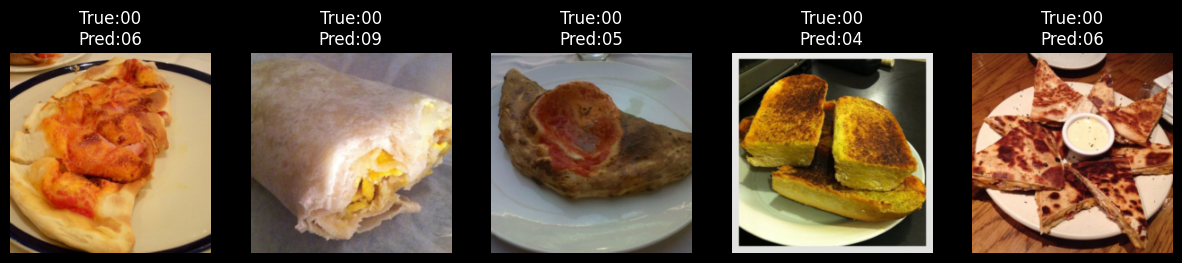

In [14]:
# 自定义模型训练
# 实例化
simple_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=1e-4)

# 训练
train_model(simple_model, train_loader, val_loader, criterion, optimizer, num_epochs=50, model_name='SimpleCNN')

# 错误样本
show_misclassified(simple_model, val_loader)

In [13]:
# 获取预处理模型
def get_model(model_name='resnet18'):
    if model_name == 'alexnet':
        model = models.alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 11)
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 11)
    elif model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 11)
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, 11)
    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 11)
    else:
        raise ValueError("Unsupported model")
    return model


d:\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.6688, Val Acc = 0.8015


Epoch 2: Train Acc=0.9367, Val Acc = 0.8394


Epoch 3: Train Acc=0.9912, Val Acc = 0.8318


Epoch 4: Train Acc=0.9990, Val Acc = 0.8621


Epoch 5: Train Acc=1.0000, Val Acc = 0.8576


Epoch 6: Train Acc=1.0000, Val Acc = 0.8455


Epoch 7: Train Acc=0.9987, Val Acc = 0.8530


Epoch 8: Train Acc=0.9997, Val Acc = 0.8470


Epoch 9: Train Acc=0.9964, Val Acc = 0.8333


Epoch 10: Train Acc=0.9990, Val Acc = 0.8485


Epoch 11: Train Acc=0.9990, Val Acc = 0.8424


Epoch 12: Train Acc=0.9961, Val Acc = 0.8485


Epoch 13: Train Acc=0.9997, Val Acc = 0.8515


Epoch 14: Train Acc=0.9935, Val Acc = 0.8167


Epoch 15: Train Acc=0.9903, Val Acc = 0.8242


Epoch 16: Train Acc=0.9922, Val Acc = 0.8379


Epoch 17: Train Acc=0.9977, Val Acc = 0.8333


Epoch 18: Train Acc=0.9961, Val Acc = 0.8333


Epoch 19: Train Acc=0.9864, Val Acc = 0.8045


Epoch 20: Train Acc=0.9958, Val Acc = 0.8379


Epoch 21: Train Acc=0.9994, Val Acc = 0.8591


Epoch 22: Train Acc=0.9968, Val Acc = 0.8606


Epoch 23: Train Acc=0.9981, Val Acc = 0.8455


Epoch 24: Train Acc=0.9994, Val Acc = 0.8530


Epoch 25: Train Acc=0.9997, Val Acc = 0.8485


Epoch 26: Train Acc=0.9951, Val Acc = 0.8258


Epoch 27: Train Acc=0.9880, Val Acc = 0.8424


Epoch 28: Train Acc=0.9984, Val Acc = 0.8636


Epoch 29: Train Acc=0.9961, Val Acc = 0.8273


Epoch 30: Train Acc=0.9974, Val Acc = 0.8394


Epoch 31: Train Acc=0.9987, Val Acc = 0.8379


Epoch 32: Train Acc=0.9873, Val Acc = 0.8197


Epoch 33: Train Acc=0.9997, Val Acc = 0.8515


Epoch 34: Train Acc=0.9997, Val Acc = 0.8500


Epoch 35: Train Acc=0.9942, Val Acc = 0.8333


Epoch 36: Train Acc=0.9990, Val Acc = 0.8515


Epoch 37: Train Acc=1.0000, Val Acc = 0.8561


Epoch 38: Train Acc=1.0000, Val Acc = 0.8576


Epoch 39: Train Acc=1.0000, Val Acc = 0.8636


Epoch 40: Train Acc=1.0000, Val Acc = 0.8591


Epoch 41: Train Acc=1.0000, Val Acc = 0.8545


Epoch 42: Train Acc=1.0000, Val Acc = 0.8561


Epoch 43: Train Acc=1.0000, Val Acc = 0.8561


Epoch 44: Train Acc=0.9981, Val Acc = 0.8470


Epoch 45: Train Acc=0.9977, Val Acc = 0.8424


Epoch 46: Train Acc=0.9994, Val Acc = 0.8424


Epoch 47: Train Acc=0.9994, Val Acc = 0.8439


Epoch 48: Train Acc=0.9994, Val Acc = 0.8439


Epoch 49: Train Acc=1.0000, Val Acc = 0.8455


Epoch 50: Train Acc=1.0000, Val Acc = 0.8409


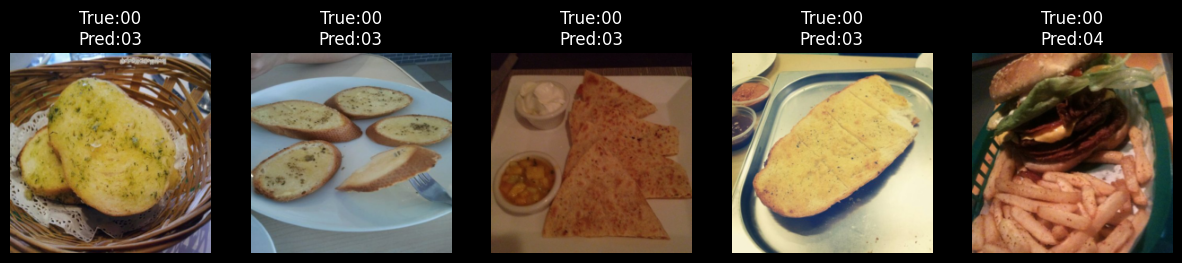

In [14]:
# ResNet 训练
# 选择模型
resnet_model = get_model('resnet18').to(device)

# 损失&优化
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=1e-4)

# 训练
train_model(resnet_model, train_loader, val_loader, criterion, optimizer, num_epochs=50, model_name='ResNet18')

# 错误样本
show_misclassified(resnet_model, val_loader)


d:\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.5162, Val Acc = 0.6864


Epoch 2: Train Acc=0.7380, Val Acc = 0.6955


Epoch 3: Train Acc=0.8364, Val Acc = 0.7197


Epoch 4: Train Acc=0.8922, Val Acc = 0.7545


Epoch 5: Train Acc=0.9273, Val Acc = 0.7197


Epoch 6: Train Acc=0.9448, Val Acc = 0.7439


Epoch 7: Train Acc=0.9659, Val Acc = 0.7621


Epoch 8: Train Acc=0.9737, Val Acc = 0.7424


Epoch 9: Train Acc=0.9805, Val Acc = 0.7682


Epoch 10: Train Acc=0.9903, Val Acc = 0.7515


Epoch 11: Train Acc=0.9935, Val Acc = 0.7500


Epoch 12: Train Acc=0.9886, Val Acc = 0.7424


Epoch 13: Train Acc=0.9919, Val Acc = 0.7424


Epoch 14: Train Acc=0.9896, Val Acc = 0.7561


Epoch 15: Train Acc=0.9955, Val Acc = 0.7576


Epoch 16: Train Acc=0.9886, Val Acc = 0.7424


Epoch 17: Train Acc=0.9964, Val Acc = 0.7424


Epoch 18: Train Acc=0.9961, Val Acc = 0.7485


Epoch 19: Train Acc=0.9964, Val Acc = 0.7667


Epoch 20: Train Acc=0.9951, Val Acc = 0.7379


Epoch 21: Train Acc=0.9802, Val Acc = 0.7439


Epoch 22: Train Acc=0.9906, Val Acc = 0.7364


Epoch 23: Train Acc=0.9955, Val Acc = 0.7500


Epoch 24: Train Acc=0.9929, Val Acc = 0.7303


Epoch 25: Train Acc=0.9929, Val Acc = 0.7652


Epoch 26: Train Acc=0.9870, Val Acc = 0.7424


Epoch 27: Train Acc=0.9955, Val Acc = 0.7409


Epoch 28: Train Acc=0.9990, Val Acc = 0.7500


Epoch 29: Train Acc=0.9984, Val Acc = 0.7652


Epoch 30: Train Acc=0.9981, Val Acc = 0.7439


Epoch 31: Train Acc=0.9932, Val Acc = 0.7348


Epoch 32: Train Acc=0.9974, Val Acc = 0.7515


Epoch 33: Train Acc=0.9981, Val Acc = 0.7424


Epoch 34: Train Acc=0.9984, Val Acc = 0.7394


Epoch 35: Train Acc=0.9994, Val Acc = 0.7712


Epoch 36: Train Acc=0.9997, Val Acc = 0.7530


Epoch 37: Train Acc=1.0000, Val Acc = 0.7727


Epoch 38: Train Acc=1.0000, Val Acc = 0.7606


Epoch 39: Train Acc=1.0000, Val Acc = 0.7773


Epoch 40: Train Acc=0.9994, Val Acc = 0.7682


Epoch 41: Train Acc=0.9964, Val Acc = 0.7455


Epoch 42: Train Acc=0.9903, Val Acc = 0.7439


Epoch 43: Train Acc=0.9831, Val Acc = 0.7455


Epoch 44: Train Acc=0.9925, Val Acc = 0.7530


Epoch 45: Train Acc=0.9919, Val Acc = 0.7561


Epoch 46: Train Acc=0.9912, Val Acc = 0.7485


Epoch 47: Train Acc=0.9955, Val Acc = 0.7455


Epoch 48: Train Acc=0.9997, Val Acc = 0.7606


Epoch 49: Train Acc=1.0000, Val Acc = 0.7712


Epoch 50: Train Acc=0.9997, Val Acc = 0.7333


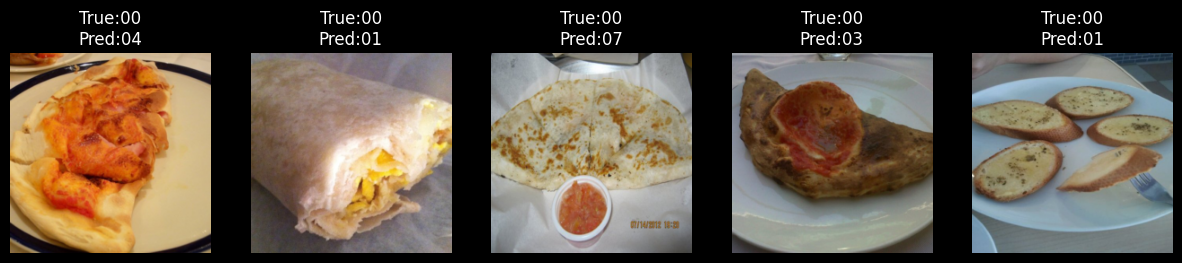

In [17]:
# AlexNet 训练
# 选择模型
alexnet_model = get_model('alexnet').to(device)

# 损失&优化
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_model.parameters(), lr=1e-4)

# 训练
train_model(alexnet_model, train_loader, val_loader, criterion, optimizer, num_epochs=50, model_name='alexnet')

# 错误样本
show_misclassified(alexnet_model, val_loader)


d:\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\ChenYL/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:02<00:00, 16.1MB/s]


Epoch 1: Train Acc=0.6364, Val Acc = 0.7970


Epoch 2: Train Acc=0.9052, Val Acc = 0.8667


Epoch 3: Train Acc=0.9718, Val Acc = 0.8773


Epoch 4: Train Acc=0.9935, Val Acc = 0.8848


Epoch 5: Train Acc=0.9938, Val Acc = 0.8758


Epoch 6: Train Acc=0.9919, Val Acc = 0.8788


Epoch 7: Train Acc=0.9971, Val Acc = 0.8788


Epoch 8: Train Acc=0.9977, Val Acc = 0.8803


Epoch 9: Train Acc=0.9945, Val Acc = 0.8833


Epoch 10: Train Acc=0.9997, Val Acc = 0.8803


Epoch 11: Train Acc=0.9994, Val Acc = 0.8909


Epoch 12: Train Acc=1.0000, Val Acc = 0.8955


Epoch 13: Train Acc=0.9974, Val Acc = 0.8894


Epoch 14: Train Acc=0.9981, Val Acc = 0.8879


Epoch 15: Train Acc=0.9984, Val Acc = 0.8773


Epoch 16: Train Acc=0.9958, Val Acc = 0.8682


Epoch 17: Train Acc=0.9955, Val Acc = 0.8773


Epoch 18: Train Acc=0.9964, Val Acc = 0.8879


Epoch 19: Train Acc=0.9945, Val Acc = 0.8621


Epoch 20: Train Acc=0.9880, Val Acc = 0.8727


Epoch 21: Train Acc=0.9981, Val Acc = 0.8924


Epoch 22: Train Acc=1.0000, Val Acc = 0.9015


Epoch 23: Train Acc=0.9997, Val Acc = 0.8879


Epoch 24: Train Acc=1.0000, Val Acc = 0.8864


Epoch 25: Train Acc=0.9987, Val Acc = 0.8833


Epoch 26: Train Acc=0.9919, Val Acc = 0.8545


Epoch 27: Train Acc=0.9968, Val Acc = 0.8712


Epoch 28: Train Acc=0.9964, Val Acc = 0.8636


Epoch 29: Train Acc=0.9987, Val Acc = 0.8712


Epoch 30: Train Acc=0.9906, Val Acc = 0.8652


Epoch 31: Train Acc=0.9981, Val Acc = 0.8606


Epoch 32: Train Acc=0.9994, Val Acc = 0.8818


Epoch 33: Train Acc=0.9964, Val Acc = 0.8727


Epoch 34: Train Acc=0.9990, Val Acc = 0.8833


Epoch 35: Train Acc=0.9958, Val Acc = 0.8606


Epoch 36: Train Acc=0.9922, Val Acc = 0.8682


Epoch 37: Train Acc=0.9935, Val Acc = 0.8591


Epoch 38: Train Acc=0.9961, Val Acc = 0.8530


Epoch 39: Train Acc=0.9981, Val Acc = 0.8773


Epoch 40: Train Acc=1.0000, Val Acc = 0.8818


Epoch 41: Train Acc=0.9997, Val Acc = 0.8818


Epoch 42: Train Acc=0.9955, Val Acc = 0.8727


Epoch 43: Train Acc=1.0000, Val Acc = 0.8833


Epoch 44: Train Acc=0.9990, Val Acc = 0.8727


Epoch 45: Train Acc=0.9971, Val Acc = 0.8818


Epoch 46: Train Acc=0.9857, Val Acc = 0.8667


Epoch 47: Train Acc=0.9925, Val Acc = 0.8682


Epoch 48: Train Acc=0.9958, Val Acc = 0.8879


Epoch 49: Train Acc=0.9987, Val Acc = 0.8682


Epoch 50: Train Acc=0.9994, Val Acc = 0.8894


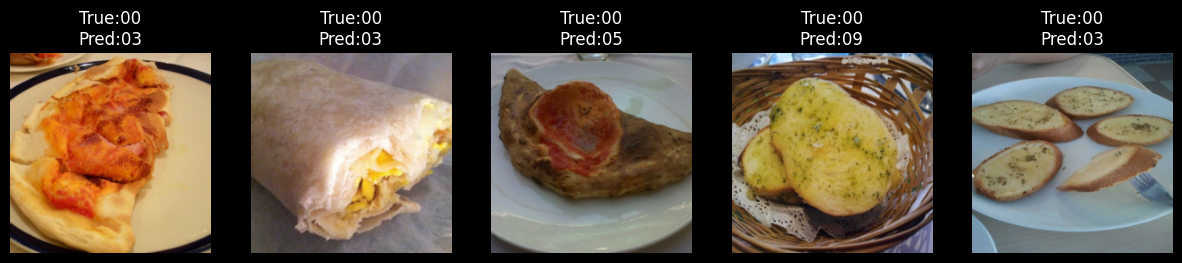

In [ ]:
# Densenet 训练
# 选择模型
densenet_model = get_model('densenet121').to(device)

# 损失&优化
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet_model.parameters(), lr=1e-4)

# 训练
train_model(densenet_model, train_loader, val_loader, criterion, optimizer, num_epochs=50, model_name='densenet')

# 错误样本
show_misclassified(densenet_model, val_loader)


d:\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\ChenYL/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 22.1MB/s]


Epoch 1: Train Acc=0.6331, Val Acc = 0.7985


Epoch 2: Train Acc=0.8688, Val Acc = 0.8606


Epoch 3: Train Acc=0.9399, Val Acc = 0.8561


Epoch 4: Train Acc=0.9760, Val Acc = 0.8727


Epoch 5: Train Acc=0.9942, Val Acc = 0.8636


Epoch 6: Train Acc=0.9961, Val Acc = 0.8652


Epoch 7: Train Acc=0.9981, Val Acc = 0.8712


Epoch 8: Train Acc=0.9997, Val Acc = 0.8697


Epoch 9: Train Acc=0.9964, Val Acc = 0.8667


Epoch 10: Train Acc=0.9938, Val Acc = 0.8621


Epoch 11: Train Acc=0.9984, Val Acc = 0.8485


Epoch 12: Train Acc=0.9994, Val Acc = 0.8712


Epoch 13: Train Acc=0.9997, Val Acc = 0.8742


Epoch 14: Train Acc=0.9987, Val Acc = 0.8667


Epoch 15: Train Acc=0.9932, Val Acc = 0.8621


Epoch 16: Train Acc=0.9984, Val Acc = 0.8545


Epoch 17: Train Acc=0.9964, Val Acc = 0.8561


Epoch 18: Train Acc=0.9981, Val Acc = 0.8591


Epoch 19: Train Acc=0.9994, Val Acc = 0.8667


Epoch 20: Train Acc=0.9997, Val Acc = 0.8606


Epoch 21: Train Acc=0.9984, Val Acc = 0.8606


Epoch 22: Train Acc=0.9997, Val Acc = 0.8682


Epoch 23: Train Acc=0.9932, Val Acc = 0.8621


Epoch 24: Train Acc=0.9841, Val Acc = 0.8545


Epoch 25: Train Acc=0.9899, Val Acc = 0.8576


Epoch 26: Train Acc=0.9981, Val Acc = 0.8636


Epoch 27: Train Acc=0.9961, Val Acc = 0.8545


Epoch 28: Train Acc=1.0000, Val Acc = 0.8561


Epoch 29: Train Acc=0.9994, Val Acc = 0.8758


Epoch 30: Train Acc=0.9997, Val Acc = 0.8652


Epoch 31: Train Acc=1.0000, Val Acc = 0.8712


Epoch 32: Train Acc=0.9997, Val Acc = 0.8667


Epoch 33: Train Acc=0.9971, Val Acc = 0.8758


Epoch 34: Train Acc=0.9977, Val Acc = 0.8636


Epoch 35: Train Acc=0.9981, Val Acc = 0.8727


Epoch 36: Train Acc=0.9977, Val Acc = 0.8606


Epoch 37: Train Acc=0.9912, Val Acc = 0.8682


Epoch 38: Train Acc=0.9994, Val Acc = 0.8803


Epoch 39: Train Acc=0.9997, Val Acc = 0.8667


Epoch 40: Train Acc=0.9997, Val Acc = 0.8530


Epoch 41: Train Acc=0.9990, Val Acc = 0.8576


Epoch 42: Train Acc=0.9994, Val Acc = 0.8652


Epoch 43: Train Acc=1.0000, Val Acc = 0.8727


Epoch 44: Train Acc=1.0000, Val Acc = 0.8682


Epoch 45: Train Acc=1.0000, Val Acc = 0.8682


Epoch 46: Train Acc=0.9987, Val Acc = 0.8530


Epoch 47: Train Acc=0.9909, Val Acc = 0.8697


Epoch 48: Train Acc=0.9851, Val Acc = 0.8636


Epoch 49: Train Acc=0.9977, Val Acc = 0.8773


Epoch 50: Train Acc=0.9877, Val Acc = 0.8515


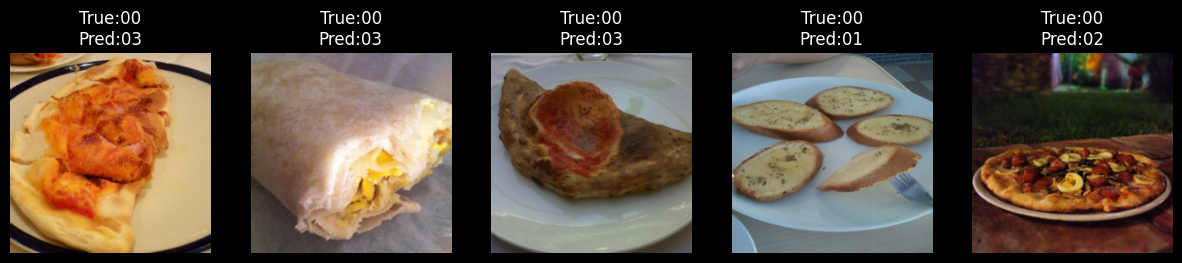

In [8]:
# MobileNet 训练
# 选择模型
mobilenet_model = get_model('mobilenet_v2').to(device)

# 损失&优化
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_model.parameters(), lr=1e-4)

# 训练
train_model(mobilenet_model, train_loader, val_loader, criterion, optimizer, num_epochs=50, model_name='mobilenet')

# 错误样本
show_misclassified(mobilenet_model, val_loader)


In [9]:
# 测试集推理
class FoodTestDataset(Dataset):
    def __init__(self, root, transform=None):
        self.image_paths = sorted([
            os.path.join(root, fname)
            for fname in os.listdir(root)
            if fname.lower().endswith(('.jpg', '.png'))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        img = Image.open(self.image_paths[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(self.image_paths[index])

In [10]:
test_dataset = FoodTestDataset(
    os.path.join(data_dir, 'testing', '00'),
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [11]:
import csv

def predict_and_save(model, test_loader, output_csv='submission.csv'):
    model.eval()
    results = []

    with torch.no_grad():
        for imgs, fname in tqdm(test_loader, desc='Predicting'):
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1).cpu().numpy()
            for fname, pred in zip(fname, preds):
                results.append((fname, pred))

    with open(output_csv, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Id', 'Category'])
        writer.writerows(results)

    print(f"预测结果保存到 {output_csv}")